In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

import sonnet as snt

from tqdm import tqdm_notebook as tqdm

tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



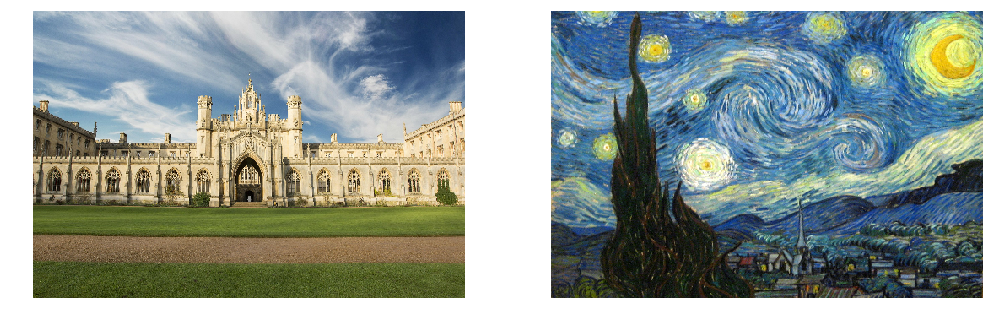

In [21]:
# no need to resize yet
raw_img = tf.read_file('johns.jpg')
content_img = tf.image.decode_image(raw_img)[None, ...]
content_img = tf.cast(content_img, tf.float32) / 255.
gen_img = content_img[:]
content_img = tf.image.resize_images(content_img, size=tuple([v // 4 for v in content_img.shape[1:3]]))
content_resized_shape = content_img.shape[1:3]

raw_img = tf.read_file('starry_night.png')
style_img = tf.image.decode_image(raw_img)[None, :, :, :-1]
style_img = tf.image.resize_images(style_img, size=content_img.shape[1:3])
style_img = tf.cast(style_img, tf.float32) / 255.

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.imshow(content_img[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(style_img[0])
plt.axis('off')
plt.show()

In [22]:
def content_loss(g_acts, c_acts, weights):
    
    return 0.5 * sum([w * tf.reduce_sum(tf.squared_difference(g_act, c_act)) 
                      for w, g_act, c_act in zip(weights, g_acts, c_acts)])

def style_loss(g_acts, s_acts, weights):
    
    loss = 0
    
    for w, g_act, s_act in zip(weights, g_acts, s_acts):
        
        g_gram = tf.einsum('bijk, bijl -> kl', g_act, g_act)
        s_gram = tf.einsum('bijk, bijl -> kl', s_act, s_act)
        
        NM = tf.cast(tf.reduce_prod(g_act.shape), tf.float32)
        
        loss += w * 0.25 / NM**2 * tf.reduce_sum(tf.squared_difference(g_gram, s_gram))
        
    return loss

def total_variation_loss(gen_img):
    
    x_deltas = gen_img[:, 1:, :, :] - gen_img[:, :-1, :, :]
    y_deltas = gen_img[:, :, 1:, :] - gen_img[:, :, :-1, :]
    
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [23]:
# Names of layers and weight values for content and style losses
content_layers = ['block4_conv2']
content_weights = [1] * len(content_layers)

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
style_weights = [1] * len(style_layers)

# Loading in VGG-19
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                          weights='imagenet',
                                          input_tensor=None,
                                          input_shape=content_img.shape[1:], 
                                          pooling='avg', 
                                          classes=1000)
vgg19.trainable = False

# Define new model to get activations
outputs = [vgg19.get_layer(layer_name).output for layer_name in (content_layers + style_layers)]
vgg19_activations = tf.keras.Model([vgg19.input], outputs)

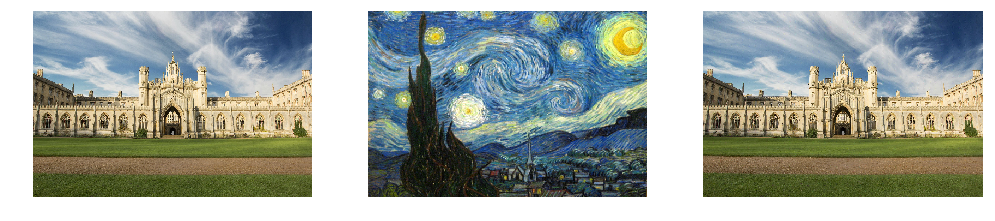

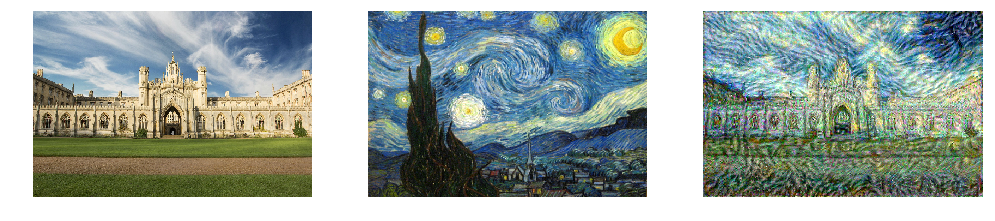

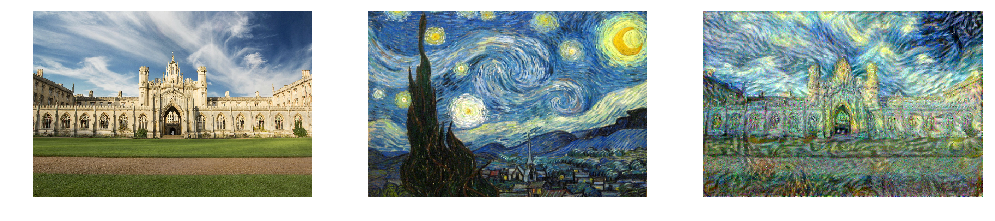

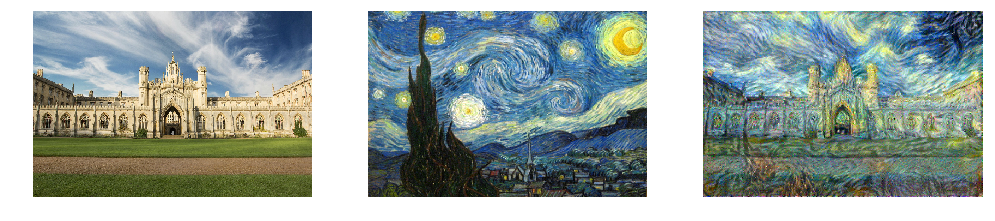

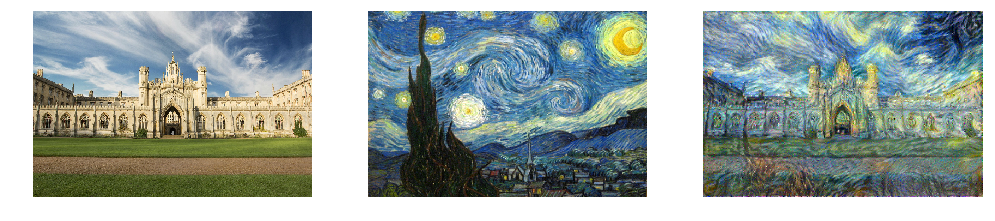

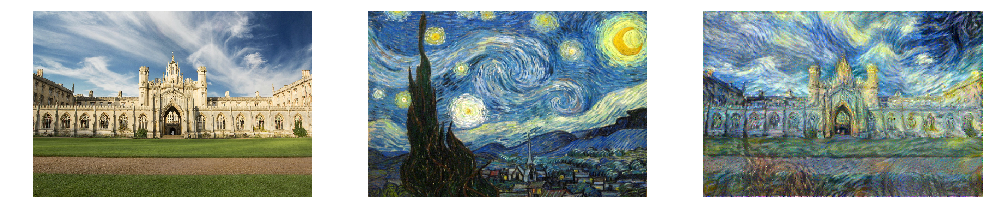

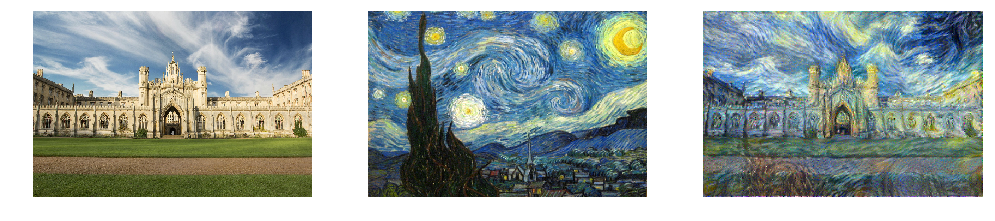

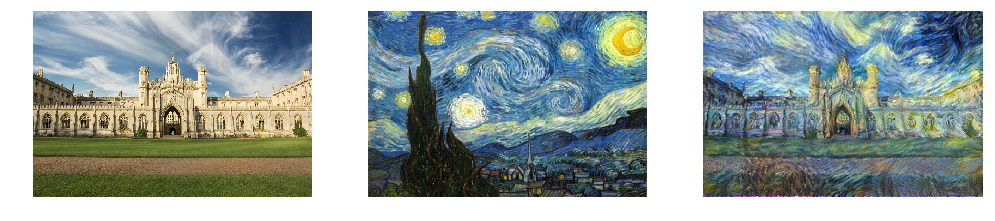

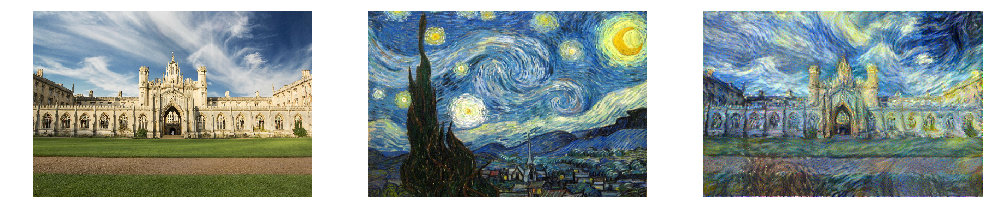

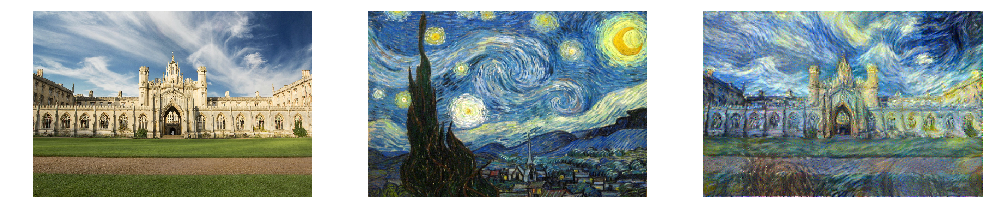

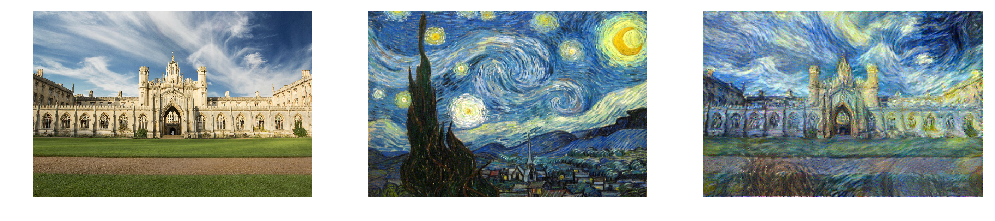

In [24]:
num_epochs = 1001
log_freq = 100
learn_rate = 2e-2
content_weight = 1
style_weight = 1e3
reg_weight = 1e8
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate, beta1=0.99, epsilon=1e-1)

# gen_img = tf.random.uniform(minval=0., maxval=1., shape=content_img.shape)
gen_img = tf.Variable(gen_img)

# Precompute content and style activatiosn
c_input = tf.keras.applications.vgg19.preprocess_input(content_img * 255.)
s_input = tf.keras.applications.vgg19.preprocess_input(style_img * 255.)

c_acts = vgg19_activations(c_input)[:len(content_layers)]
s_acts = vgg19_activations(s_input)[len(content_layers):]

for epoch in tqdm(range(num_epochs)):
    with tf.GradientTape() as tape:
        
        g_input = tf.image.resize_images(gen_img, size=content_resized_shape)
        g_input = tf.keras.applications.vgg19.preprocess_input(g_input * 255.)
        g_acts = vgg19_activations(g_input)

        c_loss = content_loss(g_acts[:len(content_layers)], c_acts, content_weights)

        s_loss = style_loss(g_acts[len(content_layers):], s_acts, style_weights)

        loss = content_weight * c_loss + style_weight * s_loss 
        loss = loss + reg_weight * total_variation_loss(gen_img)

    grads = tape.gradient(loss, gen_img)
    optimizer.apply_gradients([(grads, gen_img)])
    
    # Bring image back to a valid range
    gen_img.assign(tf.clip_by_value(gen_img, clip_value_min=0., clip_value_max=1.))

    if epoch % log_freq == 0:
        plt.figure(figsize=(17, 6))
        plt.subplot(131)
        plt.imshow(tf.squeeze(content_img).numpy())
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(tf.squeeze(style_img).numpy())
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(tf.squeeze(gen_img).numpy())
        plt.axis('off')
        plt.show()

result = tf.squeeze(gen_img).numpy()

# Save resulting image
fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(result)
plt.savefig('starry_johns.png', dpi=800) 
plt.close()

In [26]:
! wget https://scontent-lht6-1.xx.fbcdn.net/v/t31.0-8/17758383_1310525318995676_7741233786047357227_o.jpg?_nc_cat=104&_nc_ht=scontent-lht6-1.xx&oh=660df07f974b5f1db401331849869d06&oe=5D94E630
! 17758383_1310525318995676_7741233786047357227_o.jpg joshua.jpg

/bin/sh: 1: 17758383_1310525318995676_7741233786047357227_o.jpg: not found
